In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
#Zone di interesse (rappresentazione grafica)
r = 0.3
S=[0,1]  
I=[0,1]

#Zone di transizione, recupero, fatalità

P_SI=0.005 #Percentuale da suscettibili a infetti
s=0.1
S0=[s,s+P_SI*(S[-1]-S[0])]

P_IR=0.015 #Percentuale da infetti a guariti
s=0.8
R=[s,s+P_IR*(I[-1]-I[0])]

P_IF=0.015 #Percentuale da infetti a deceduti
s= 0.815
F=[s,s+P_IF*(I[-1]-I[0])]

# Numero di individui del campione
M = 100000
# Numero di iterazioni per la simulazione
N = 500
# Coefficiente di proporzionalità k per il potenziale di infettività
k = 0.04

In [3]:
#Matrice sparsa di contagio
def generate_sparse_matrix(n_righe, n_colonne, m=5):

    # Genero gli indici di riga per inserire i k valori non nulli
    righe = np.repeat(np.arange(n_righe), m)        #Generiamo righe lunghe n_righe*m di elemnti da 0 a n_rows-1 ripetuto m volte

    colonne = np.empty(n_righe * m, dtype=np.int32) #Generiamo colonne lunghe n_righe*m di numeri casuali interi a 32 bit (per conservare memoria)                      

    for i in range(n_righe):
        n_colonne_corrette = np.delete(np.arange(n_colonne), i)
        #Generiamo un array di numeri casuali di lunghezza n_colonne in cui eliminiamo l'elemento dellìindice del ciclo
        colonne[i*m:(i+1)*m] = np.random.choice(n_colonne_corrette, size=m, replace=False)         
        #Selezioniamo m diversi elemnti delle colonne corrette senza ripetizioni e le salvo al posto delle colonne di indice [i*m:(i+1)*m]
                                                                                 
        #Creo quindi indici di riga e colonna a cui successivamente attribuisco valore 1 
   
    valori= np.ones(n_righe * m)

    return csr_matrix((valori, (righe, colonne)), shape=(n_righe, n_colonne))
    
#Traiettoria associata alla mappa
def Traiettoria(u, r):
    if u < r:
        return u / r
    else:
        return (1 - u) / (1 - r)



In [4]:
def K_operatore(x, y, A, r, k, S0, R, F, vivo):
    
    x_new=x.copy()
    y_new=y.copy()
    K=np.empty(M)
    contatore_infetti=np.zeros(M)

    for i in range(M):
        if not vivo[i]:
            continue  # Fuori dal sistema se si è stati in F

        # Considero solo gli stati suscettibili in S1
        if y[i] == 0 and not (S0[0] <= x[i] < S0[1]):
            vicino = A[i].indices
            infettivi = []
            # Estraggo come array le entrate non nulle della matrice sparsa A
            for n in vicino:
                if not vivo[n]:
                    continue  # Un morto non contagia (si spera, sennò apocalisse zombie)
                if y[n] == 1: #and not (R[0] <= x[n] < R[1] or F[0] <= x[n] < F[1]):
                    infettivi.append(n)
            # Verifico che l'array infectious non sia vuoto
            if infettivi:
                # Calcolo K_i = k * max(x_n)
                K[i] = k * max(x[l] for l in infettivi)
                # Regola soglia
                if x[i] + K[i] > 1.0:
                    x_new[i] = x[i] + K[i] - 1.0
                    y_new[i] = 1
                    contatore_infetti[i] = 1

    return x_new, y_new, contatore_infetti

In [5]:
#Costruiamo una matrice sparsa
A=generate_sparse_matrix(M, M)

#Condizioni iniziali M soggetti tutti suscettibili
x=np.random.rand(M)
y=np.zeros(M, dtype=np.int8)           
x_next=np.empty(M)
y_next=np.zeros(M, dtype=np.int8)
vivo = np.ones(M, dtype=bool)      #Inizialmente son tutti vivi, è una variabile booleana

#Creo una lista di valori da aggiorna delle z
z_n=[]
# Seleziono un individuo randomicamente
individuo=np.random.randint(M)

#Creo istogrammi associati a ogni regione
S_hist = np.empty(N)
S0_hist = np.empty(N)
I_hist = np.empty(N)
R_hist = np.empty(N)
F_hist = np.empty(N)
K_hist = np.empty(N)

for n in range(N):                             #ciclo per n passi temporali
  for i in range(M):                           #solo i vivi aggiornano la propria dinamica
      if not vivo[i]:
          continue

      x_next[i] = Traiettoria(x[i], r)
      if y[i] == 0:  # S
          y_next[i] = 1 if (S0[0] <= x[i] < S0[-1]) else 0
      else:          # I
          y_next[i] = 0 if (R[0] <= x[i] < R[-1]) or (F[0] <= x[i] < F[-1]) else 1

      x[i], y[i] = x_next[i], y_next[i]

  #eliminiamo i morti per non farli interagire
  morto = vivo & (x >= F[0]) & (x < F[-1])  #se un individuo ha la x in un certo intervallo di F viene dichiarato morto 
  if np.any(morto):                          #np.any controlla se almeno un elemento dell'array è "vero"
      vivo[morto] = False
      y[morto] = -1                          #Non lo usiamo ma li classifichiamo comunque

  #Contagio di rete (tra soli vivi)
  x, y, contatore_infetti = K_operatore(x, y, A, r, k, S0, R, F, vivo)
      
    
  #costruiamo una liosta di valori di z in funzione del loro stato
  z_n.append(x[individuo] + (1 if (vivo[individuo] and y[individuo] == 1) else 0))

  #Per la normalizzazione delle frazioni consideriamo solo il numero di vivi
  M_vivo = max(1, vivo.sum())

  in_K = (contatore_infetti == 1)
  in_I = vivo & (y == 1)
  in_S0 = vivo & (y == 0) & (x >= S0[0]) & (x < S0[1])
  in_R = vivo & in_I & (x >= R[0]) & (x < R[1])
  in_F = ~vivo                                           #conta se non è vivo
  in_S = vivo & (y == 0)

  S_hist[n] = in_S.sum() / M_vivo
  I_hist[n] = in_I.sum() / M_vivo
  R_hist[n] = in_R.sum() / M_vivo
  S0_hist[n] = in_S0.sum() / M_vivo
  #consideriamo la frazione di morti rispetto al totale della mia popolazione
  F_hist[n] = in_F.sum() / M

  #Nuovi infettati dalla rete normalizzati sui vivi, 0 se muoiono tutti
  K_hist[n] = contatore_infetti[vivo].mean() if vivo.any() else 0.0

print(f"Frazione di vivi finali: {vivo.sum()}/{M}  |  Defunti (F): {M - vivo.sum()} ({F_hist[-1]:.3f})")
print(f"Ultime frazioni sui vivi: S={S_hist[-1]:.3f}  I={I_hist[-1]:.3f}  R={R_hist[-1]:.3f}")
print(f"Frazione di infetti dalla rete: K={K_hist[-1]:.3f}")


Frazione di vivi finali: 163/100000  |  Defunti (F): 99837 (0.998)
Ultime frazioni sui vivi: S=0.736  I=0.264  R=0.006
Frazione di infetti dalla rete: K=0.000


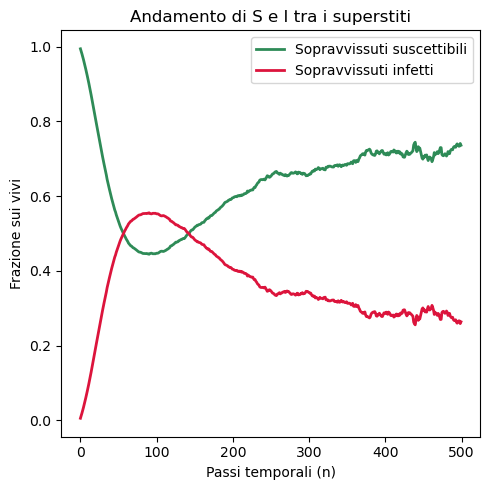

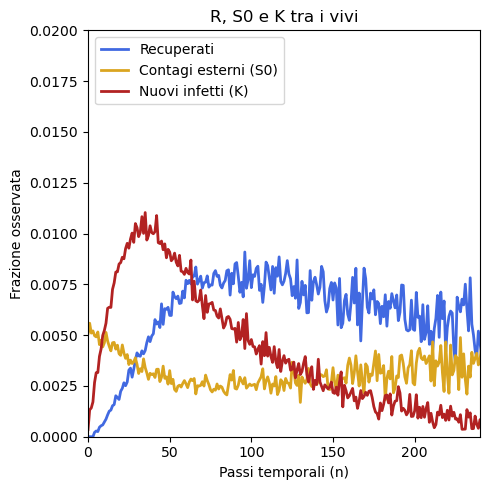

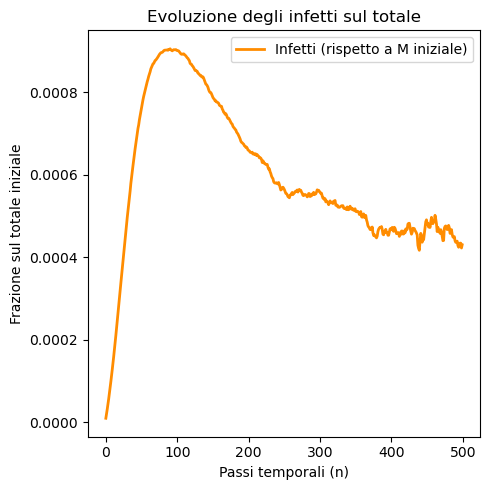

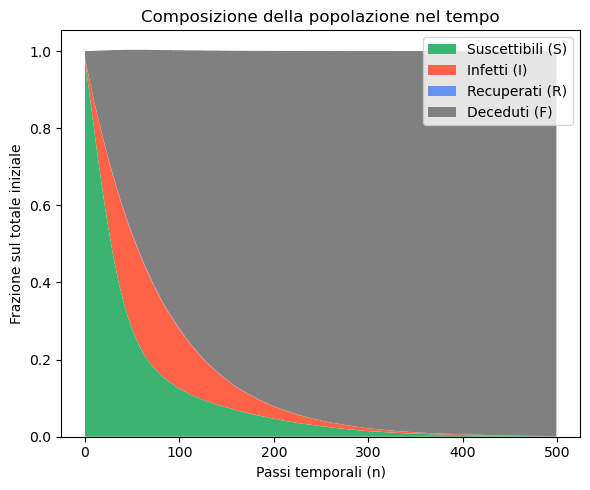

In [23]:
t = np.arange(N)

# 1) Curve S(n), I(n) sui vivi
plt.figure(figsize=(5, 5))
plt.plot(t, S_hist, label="Sopravvissuti suscettibili", lw=2, color="seagreen")
plt.plot(t, I_hist, label="Sopravvissuti infetti", lw=2, color="crimson")
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione sui vivi")
plt.title("Andamento di S e I tra i superstiti")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("S vs I.png")
plt.show()

# 2) R(n) sui vivi + S0 e K
plt.figure(figsize=(5, 5))
plt.xlim(0, 240)
plt.ylim(0, 0.02)
plt.plot(t, R_hist, label="Recuperati", lw=2, color="royalblue")
plt.plot(t, S0_hist, label="Contagi esterni (S0)", lw=2, color="goldenrod")
plt.plot(t, K_hist, label="Nuovi infetti (K)", lw=2, color="firebrick")
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione osservata")
plt.title("R, S0 e K tra i vivi")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("Andamento stati su frazioni.png")
plt.show()

# 3) Curva I(n) sui vivi ma normalizzata a M iniziale
plt.figure(figsize=(5, 5))
plt.plot(t, I_hist * M_vivo / M, label="Infetti (rispetto a M iniziale)", lw=2, color="darkorange")
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione sul totale iniziale")
plt.title("Evoluzione degli infetti sul totale")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("Curva infetti.png")
plt.show()

# 4) Area (S + I + R sui vivi) + F rimossi = 1
frazione_vivi = 1.0 - F_hist
S_global = S_hist * frazione_vivi
I_global = I_hist * frazione_vivi
R_global = R_hist * frazione_vivi
F_global = F_hist

plt.figure(figsize=(6, 5))
plt.stackplot(
    t,
    S_global, I_global, R_global, F_global,
    labels=["Suscettibili (S)", "Infetti (I)", "Recuperati (R)", "Deceduti (F)"],
    colors=["mediumseagreen", "tomato", "cornflowerblue", "gray"]
)
plt.xlabel("Passi temporali (n)")
plt.ylabel("Frazione sul totale iniziale")
plt.title("Composizione della popolazione nel tempo")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Distribuzioni aree con morte.png")
plt.show()
